# Creating Reproducible, Publication-Quality Plots with Matplotlib and Seaborn

**Update:** this post was created from a Jupyter notebook, which you can access [here](https://nbviewer.jupyter.org/github/jhamrick/blog/blob/master/source/notebooks/reproducible-plots.ipynb).

How should you create a plot for inclusion in a publication? A common workflow for Matlab or Python users—and one that I used to use myself—is to create a figure just using the defaults, export it as SVG, and open it Inkscape or Illustrator to make it look nice.

This works fine if you only need to edit how a figure looks once. However, this is almost never the case. As you iterate further on the paper, your advisor may ask you to generate the plot a slightly different way. Or, perhaps, you find an off-by-one error in your code and need to regenerate the figure with the correct results. However, having to go through the whole process of re-editing your figures in a vector graphics program can take a *lot* of time, and thus this added time cost may discourage you from regenerating figures (even when you really should).

However, there is another option, albeit with a higher startup cost. If you use Python, then Matplotlib actually exposes almost all the controls you need to make instantly reproducible, beautiful figures. The high startup cost is learning how to use those controls, which can take a lot of effort. However, I'd argue that this startup cost is entirely worth it. After having used Matplotlib exclusively for my figures since starting graduate school, I can now create a fully reproducible, publication-quality figure in about 10 minutes. In this blog post, I'll walk you through the steps needed to go from Matplotlib's defaults, to something useable in a publication.

## Setup

Before I get started, I will import all the libraries that I need (except Seaborn, which I'll import and talk about later on). The libraries I need are [matplotlib](http://matplotlib.org/), [pandas](http://pandas.pydata.org/), and [numpy](http://www.numpy.org/). Below, I also print out the version of Python that I am using (3.5) as well as versions of each of the libraries:

In [1]:
# Special matplotlib import for the Jupyter notebook
%matplotlib inline

In [2]:
# Built-in python libraries
import sys
import os
from urllib.request import urlretrieve

# 3rd-party libraries I'll be using
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("Python version:\n{}\n".format(sys.version))
print("matplotlib version: {}".format(matplotlib.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))

Python version:
3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]

matplotlib version: 1.5.1
pandas version: 0.17.1
numpy version: 1.10.4


Now that I've imported the libraries I need, I'll download the data that I'll be plotting:

In [3]:
url = "https://gist.githubusercontent.com/jhamrick/cfa18fcd3032ba435ec78a194b1447be/raw/4a4052c56161df8e454a61ab5286a769799c64b8/task_data.csv"
urlretrieve(url, "task_data.csv")
print("Downloaded task_data.csv")

Downloaded task_data.csv


The data are from a recent publication of mine in which we were studying human-robot collaboration. Specifically, we looked at how different robot behaviors affected the completion of a set of tasks, both in terms of objective measures (such as completion time, or how equally the robot and human shared tasks) and subjective measures of preferences. In our experiment, we had three different robot behaviors (*fixed*, *reactive*, and *predictive*), and two different ways the robot obtained information about the human's goals (*oracle*, in which the robot had perfect knowledge, and *Bayesian*, in which the robot infers the human's goals based on their motion). For further details on the experimental design, please check out [the paper](http://www.jesshamrick.com/publications/pdf/Liu2016-Goal_Inference_Improves_Objective.pdf).

Here, I'll be taking a look at the objective measure of how many tasks the robot completed. The data includes information about how many tasks the human completed, how many the robot completed, and how many were completed simultaneously by both agents:

In [4]:
task_data = pd.read_csv("task_data.csv")
task_data.head()

,pid,robot,inference,human_tasks,robot_tasks,both_tasks,total_tasks
0,00d648c5,fixed,oracle,15,15,9,39
1,00d648c5,predictive,oracle,23,15,1,39
2,00d648c5,reactive,oracle,18,17,4,39
3,01276036,fixed,oracle,25,11,3,39
4,01276036,predictive,oracle,25,14,0,39


## A first attempt

So, what I'd like to do is create a plot that shows how many tasks the robot completed for each behavior type (fixed, reactive, or predictive) and each inference type (oracle or bayesian). The appropriate type of plot for this sort of data is probably a bar plot (or variants thereof, such as a box plot or violin plot). Thus, I first need to compute the values of the bars, which I'll take to just be the mean across participants:

In [5]:
tasks = task_data.groupby(['robot', 'inference'])['robot_tasks'].mean()
tasks

robot       inference
fixed       bayesian     11.474227
            oracle       11.696970
predictive  bayesian     16.814433
            oracle       15.121212
reactive    bayesian     12.793814
            oracle       12.808081
Name: robot_tasks, dtype: float64

Now, I can create my plot! I'll put the code to create the plot in a function called `plot_v1` just so I have easy access to it later, and also to differentiate it from different ways of creating the plot that I'll explore later:

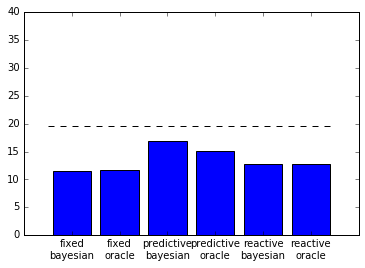

In [6]:
def plot_v1(data):
    # Create the figure and axis objects I'll be plotting on
    fig, ax = plt.subplots()
    
    # Plot the bars
    ax.bar(np.arange(len(data)), data, align='center')
    
    # Show the 50% mark, which would indicate an equal
    # number of tasks being completed by the robot and the
    # human. There are 39 tasks total, so 50% is 19.5
    ax.hlines(19.5, -0.5, 5.5, linestyle='--', linewidth=1)
    
    # Set a reasonable y-axis limit
    ax.set_ylim(0, 40)
    
    # Apply labels to the bars so you know which is which
    ax.set_xticks(np.arange(len(data)))
    ax.set_xticklabels(["\n".join(x) for x in data.index])
    
    return fig, ax


plot_v1(tasks);

Not terrible, but not super pretty either. For one, the bars are all the same color, which makes it difficult to differentiate between them. The tick labels are also overlapping, which makes them difficult to read.

## Seaborn

One way that you can instantly improve the style of your plots is to use a package called [seaborn](https://stanford.edu/~mwaskom/software/seaborn/). Seaborn comes with a nice default style that is applied as soon as it is imported, among a number of other incredibly useful functions.

In [7]:
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

seaborn version: 0.7.0


Let's see how this plot changes, just with Seaborn's default style:

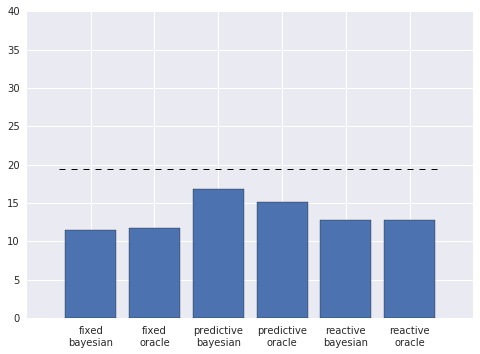

In [8]:
plot_v1(tasks);

Much nicer! The colors are easier on the eyes, and the labels aren't overlapping. There are still a number of other improvements I can make, however.

## Error bars

One incredibly important aspect of publication-quality figures is to always include appropriate error bars. Many people use standard deviation or standard error, but I am personally a fan of bootstrapped confidence intervals. Seaborn also seems to agree with me, and includes functionality to calculate and plot the error bars for you! To use this functionality, I'll rely on Seaborn's [barplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/categorical.html#bar-plots) function:

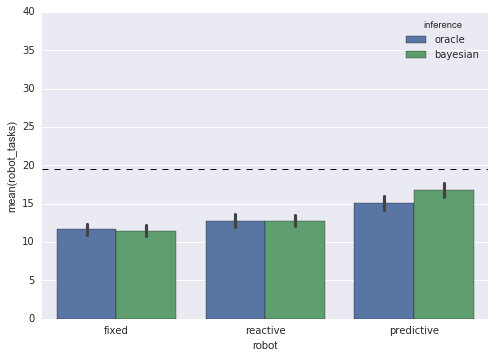

In [9]:
def plot_v2(data):
    # Create the bar plot
    ax = sns.barplot(
        x="robot", y="robot_tasks", hue="inference",
        order=["fixed", "reactive", "predictive"],
        hue_order=["oracle", "bayesian"],
        data=data)

    # Plot the 50% line
    ax.hlines(19.5, -0.5, 4.5, linestyle='--', linewidth=1)
    ax.set_ylim(0, 40)
    
    # Return the figure object and axis
    return plt.gcf(), ax


plot_v2(task_data);

## Labels

The `barplot` function gives us a legend telling us which color corresponds to which inference type. But, for this plot, I'd actually like to put the inference types under the bars as ticklabels, and then label each group of bars with the robot type. I can accomplish this by splitting the plot into three subplots, which is quite easy to do using Seaborn's [FacetGrid](https://stanford.edu/~mwaskom/software/seaborn/tutorial/axis_grids.html):

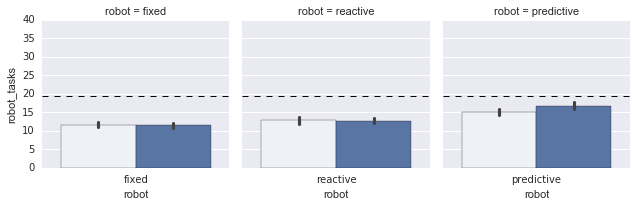

In [10]:
def plot_v3(data):
    # Specify that I want each subplot to correspond to
    # a different robot type
    g = sns.FacetGrid(
        data,
        col="robot",
        col_order=["fixed", "reactive", "predictive"],
        sharex=False)

    # Create the bar plot on each subplot
    g.map(
        sns.barplot,
        "robot", "robot_tasks", "inference",
        hue_order=["oracle", "bayesian"])

    # Now I need to draw the 50% lines on each subplot
    # separately
    axes = np.array(g.axes.flat)
    for ax in axes:
        ax.hlines(19.5, -0.5, 0.5, linestyle='--', linewidth=1)
        ax.set_ylim(0, 40)

    # Return the figure and axes objects
    return plt.gcf(), axes


plot_v3(task_data);

Nice! But the labels are still not actually how I'd like them. I'll create a new function, `set_labels`, that actually sets them to how I'd like them:

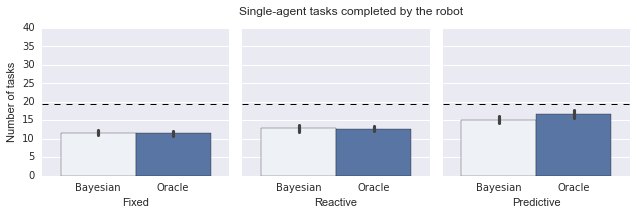

In [11]:
def set_labels(fig, axes):
    # These are the labels of each subplot
    labels = ["Fixed", "Reactive", "Predictive"]
    
    # Iterate over each subplot and set the labels
    for i, ax in enumerate(axes):

        # Set the x-axis ticklabels
        ax.set_xticks([-.2, .2])
        ax.set_xticklabels(["Bayesian", "Oracle"])

        # Set the label for each subplot
        ax.set_xlabel(labels[i])
        
        # Remove the y-axis label and title
        ax.set_ylabel("")
        ax.set_title("")
    
    # Set the y-axis label only for the left subplot
    axes.flat[0].set_ylabel("Number of tasks")
    
    # Remove the "spines" (the lines surrounding the subplot)
    # including the left spine for the 2nd and 3rd subplots
    sns.despine(ax=axes[1], left=True)
    sns.despine(ax=axes[2], left=True)

    # Set the overall title for the plot
    fig.suptitle("Single-agent tasks completed by the robot", fontsize=12, x=0.55)


fig, axes = plot_v3(task_data)
set_labels(fig, axes)

## Style

The plot is looking much nicer at this point. However, it is still somewhat visually cluttered. For one, the background and gridlines are quite distracting. Additionally, I'd like to make the font match the text of the paper, which is a times-like serif. To do these things, I will define an additional `set_style` function that utilizes some of the methods that Seaborn exposes for controlling [figure aesthetics](https://stanford.edu/~mwaskom/software/seaborn/tutorial/aesthetics.html):

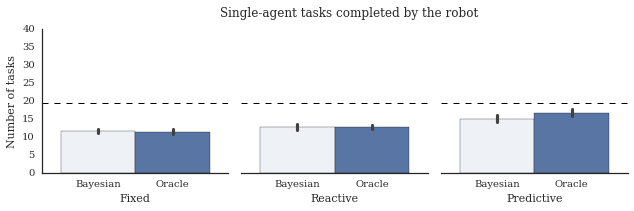

In [12]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })


set_style()
fig, axes = plot_v3(task_data)
set_labels(fig, axes)

## Colors

The plot really is almost there at this point. The last major change that I want to make is to adjust the colors. Specifically, I'd like to give each group of bars (corresponding to a robot type) a different color, and then make the individual bars (corresponding to inference types) lighter versions of those colors with hatch marks in the original color. To do this, I'll first specify an array with the colors I'd like for my bars:

In [13]:
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
        [0.984375, 0.7265625, 0], # dark yellow
        [1, 1, 0.9]               # light yellow
    ])

Seaborn comes with a nice convenience function for showing a set of colors, called `palplot`. I can use this to visualize my palette:

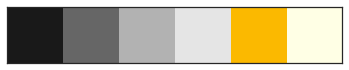

In [14]:
sns.palplot(get_colors())

Now, I need to color each bar individually. This is a bit annoying to do, because the way I want to color the bars is somewhat nonstandard. Essentially, what I need to do is find each *patch*—matplotlib's terminology for the rectangle that corresponds to a bar—and set the color and hatch marks of each of these patches separately. I define the `color_bars` function to do just this:

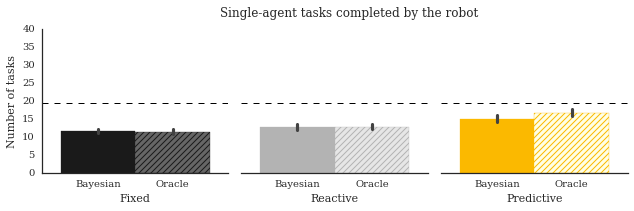

In [15]:
def color_bars(axes, colors):
    # Iterate over each subplot
    for i in range(3):

        # Pull out the dark and light colors for
        # the current subplot
        dark_color = colors[i*2]
        light_color = colors[i*2 + 1]

        # These are the patches (matplotlib's terminology
        # for the rectangles corresponding to the bars)
        p1, p2 = axes[i].patches

        # The first bar gets the dark color
        p1.set_color(dark_color)
        
        # The second bar gets the light color, plus
        # hatch marks int he dark color
        p2.set_color(light_color)
        p2.set_edgecolor(dark_color)
        p2.set_hatch('////')


set_style()
fig, axes = plot_v3(task_data)
set_labels(fig, axes)
color_bars(axes, get_colors())

## Plot sizing

The last thing I want to change is a smaller detail, which is the actual size of the plot. The above plot is much too wide for a single-column plot, so I need to resize it. Picking what size in inches you want for your plot is a bit of just trial-and-error, but I typically find that for single-column plots, a width of 6 inches typically works well:

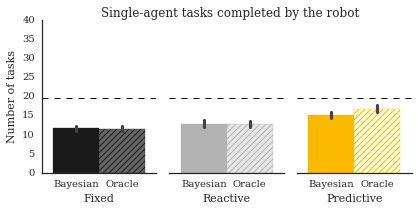

In [16]:
def set_size(fig):
    fig.set_size_inches(6, 3)
    plt.tight_layout()


set_style()
fig, axes = plot_v3(task_data)
set_labels(fig, axes)
color_bars(axes, get_colors())
set_size(fig)

## Conclusion

That's it! It may seem like a lot to learn to create just a single plot, but much of the code used to style this plot actually ends up being the same for most of the plots you create. All of the following operations are things I do in almost every single plot I create:

* Set the x- and y-axis tick locations and labels
* Set the x- and y-axis labels
* Set the subplot and/or figure titles
* Remove the top and right spines
* Remove visual tick marks
* Set the style to be "white" and the context to be "paper"
* Set the figure size and call `plt.tight_layout()`

The most unique thing about this particular plot is the way that I colored the bars, which (as I mentioned) is a bit nonstandard. However, now that I've figured out how to do that, I can reuse the code for similar plots. As it turned out, I needed to create three separate plots for this paper using the same bar coloring. Rather than having to color the bars by hand for each plot individually, I was able to figure out how to do it programmatically for one plot, and then reuse that code for the other plots.